### Mapping northern lights probability over North America and possible high elevation view points from specific geographic locations.


How well can the urban populace see astronomonical events, such as the Northern Lights and other phenomena?


These events primarily require high elevation and dark skies, which are hard to come by in large metropolitan areas such as New York, Toronto, Seattle etc.

In [30]:
!pip install mapclassify

In [ ]:
!pip install rasterio

In [21]:
# Common imports including dataframe management, mapping, file io, and helpers for extraction zips and tars
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np

import mapclassify

import rasterio

import zipfile
import os
import datetime
from pathlib import PurePath, Path


# Bring in requests for making HTTP API calls
import requests as req
from urllib.parse import urlparse

In [3]:
# NOAA's Space Weather Prediction Center (SPWC)
aurora_data_url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'

# Same data but from the G4 geomagnetic storm on 2025-11-12
peak_aurora_data_url = 'https://raw.githubusercontent.com/srujan964/ruc-gis/refs/heads/main/data/2025-11-12T04%3A59%3A51%2B00%3A00-aurora.csv'

In [4]:
USE_PEAK_DATA = True

if USE_PEAK_DATA:
  print('reading peak aurora data')
  # While reading csv data, convert the `coordinates` column to python's list type
  # NOTE: This seems to take a lot of time, need to find another, faster way to do this without evaluation the value from a string
  aurora_df = pd.read_csv(peak_aurora_data_url, converters={'coordinates': pd.eval})
else:
  print('reading current aurora data')
  aurora_df = pd.read_json(aurora_data_url)
aurora_df.head()

reading peak aurora data


,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type
0,0,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 4]",MultiPoint
1,1,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint
2,2,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 6]",MultiPoint
3,3,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 7]",MultiPoint
4,4,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 9]",MultiPoint


In [5]:
# all the values are for current time
aurora_df['Observation Time']

,Observation Time
0,2025-11-12T04:51:00Z
1,2025-11-12T04:51:00Z
2,2025-11-12T04:51:00Z
3,2025-11-12T04:51:00Z
4,2025-11-12T04:51:00Z
...,...
65155,2025-11-12T04:51:00Z
65156,2025-11-12T04:51:00Z
65157,2025-11-12T04:51:00Z
65158,2025-11-12T04:51:00Z


In [6]:
aurora_df['coordinates']

,coordinates
0,"[0, -90, 4]"
1,"[0, -89, 0]"
2,"[0, -88, 6]"
3,"[0, -87, 7]"
4,"[0, -86, 9]"
...,...
65155,"[359, 86, 0]"
65156,"[359, 87, 0]"
65157,"[359, 88, 0]"
65158,"[359, 89, 0]"


In [7]:
# Looking at only the Northern Hemisphere
# and within the longitudinal ranges of United States (including Alaska), with some padding

min_lat, max_lat = 1, 90
min_long, max_long = 0, 360

In [ ]:
aurora_df['coordinates']

In [8]:
# Explode coordinates into their own columns, makes it easier to query

split_columns = pd.DataFrame(aurora_df['coordinates'].tolist(), columns=['longitude', 'latitude', 'aurora'])
aurora_df = pd.concat([aurora_df, split_columns], axis=1)
aurora_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
0,0,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 4]",MultiPoint,0,-90,4
1,1,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint,0,-89,0
2,2,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 6]",MultiPoint,0,-88,6
3,3,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 7]",MultiPoint,0,-87,7
4,4,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 9]",MultiPoint,0,-86,9
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [9]:
aurora_df = aurora_df[aurora_df['longitude'].isin(range(min_long, max_long+1)) & aurora_df['latitude'].isin(range(min_lat, max_lat + 1))]
aurora_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,91,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,0,1,0
92,92,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,0,2,0
93,93,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,0,3,0
94,94,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,0,4,0
95,95,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,0,5,0
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [10]:
longitudes = np.array(aurora_df['longitude'])
np.mod(-longitudes, 360) - 180

array([-180, -180, -180, ..., -179, -179, -179])

In [11]:
aurora_corrected_df = aurora_df.copy()
# Convert longitudes from [0, 360] to [180, -180]
aurora_corrected_df['longitude'] = np.mod( - np.array(aurora_df['longitude']), 360) -180

aurora_corrected_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,91,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,-180,1,0
92,92,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,-180,2,0
93,93,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,-180,3,0
94,94,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,-180,4,0
95,95,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,-180,5,0
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,-179,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,-179,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,-179,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,-179,89,0


In [12]:
aurora_df.query('latitude == 0 & aurora > 0')

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora


In [ ]:
# Giant dataset from the CEC (International Collaboration on Environment Issues) with elevation data for Canada, United States, and Mexico
!curl -o elevation.zip https://www.cec.org/files/atlas_layers/0_reference/0_03_elevation/elevation_mappackage.zip

In [ ]:
# Nightime lights dataset from the same source - https://www.cec.org/files/atlas_layers/4_human_influence/4_01_nighttime_lights_2010/nighttimelights_2010_mappackage.zip

In [ ]:
elevation_zipfile = zipfile.ZipFile('elevation.zip')
elevation_dir = 'elevation'
if not os.path.isdir(elevation_dir):
  os.mkdir(elevation_dir)
if len(os.listdir(elevation_dir)) == 0:
  elevation_zipfile.extractall(elevation_dir)

In [ ]:
!pip install py7zr

In [ ]:
import py7zr

mpkg_dir = PurePath(elevation_dir, 'elevation_mappackage')
mpkg_file = Path(mpkg_dir, 'Elevation.mpkx')

elevation_data_dir = PurePath(elevation_dir, 'data')
if not os.path.isdir(elevation_data_dir):
  os.mkdir(elevation_data_dir)

with py7zr.SevenZipFile(mpkg_file, 'r') as sevenz_file:
  sevenz_file.extractall(str(elevation_data_dir))


In [13]:
na_gdf = gpd.read_file('elevation/data/commondata/na_politicaldivisions/boundaries_p_2021_v3.shp')
na_gdf.crs

<Projected CRS: PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Ar ...>
Name: Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: D_Sphere_ARC_INFO
- Ellipsoid: Sphere_ARC_INFO
- Prime Meridian: Greenwich

In [14]:
# Create a GDF from the aurora coordinate data with the WGS 84 coordinate system
# Projection code: EPSG:4326
aurora_points = gpd.GeoDataFrame(aurora_corrected_df, geometry=gpd.points_from_xy(aurora_corrected_df.longitude, aurora_corrected_df.latitude), crs='EPSG:4326')

In [15]:
# Convert the aurora map to Lambert-Azimuthal Equal Area projection to match the original projection of the base map
# This preserves the curvature of Northern polar region that compliments the shape of Aurora formation
crs_lambert_azimuthal = na_gdf.crs
aurora_points_lambert = aurora_points.to_crs(crs_lambert_azimuthal)

In [16]:
import datetime

peak_date = '2025-11-12'
current_date = datetime.date.today()

display_date = datetime.datetime.strptime(peak_date, '%Y-%m-%d').strftime('%A, %d %b %Y') if USE_PEAK_DATA else current_date.strftime('%a %d %b %Y')

<Axes: >

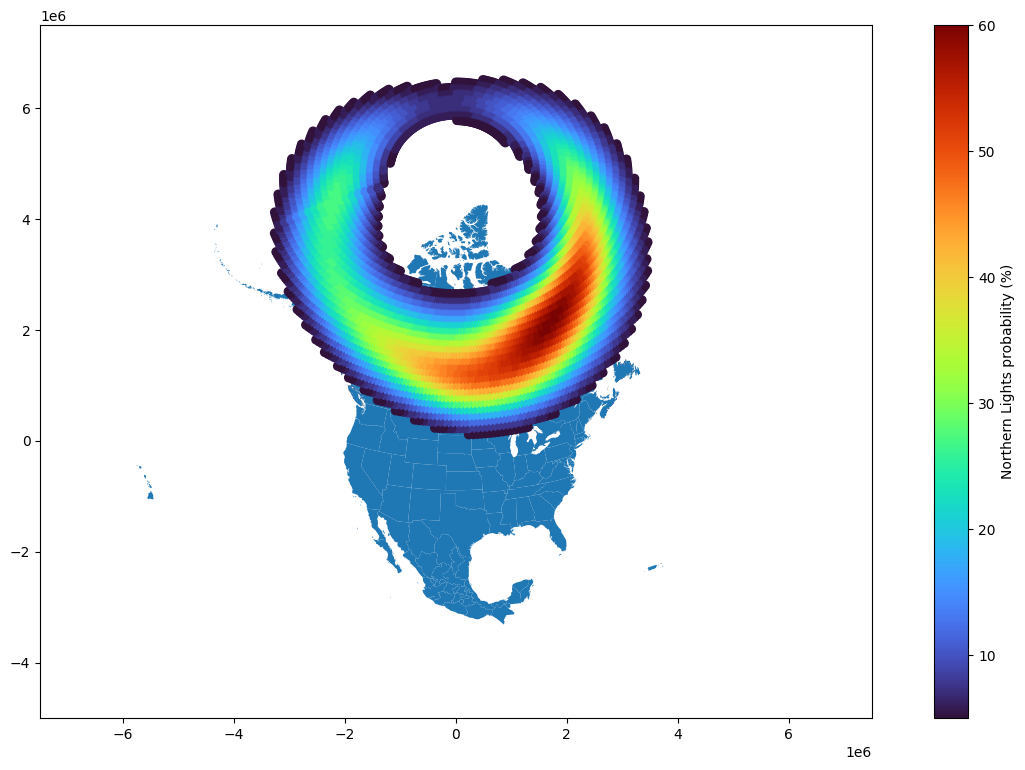

In [17]:
fig, ax = plt.subplots(1, figsize=(16,9))

# Limit the axes, which are no longer in lat-long coordinates but in metres.
ax.set_xlim([-0.75e7, 0.75e7])
ax.set_ylim([-0.50e7, 0.75e7])
na_gdf.plot(ax=ax)

# the Turbo colormap works well to show intensity
turbo_cmap = mpl.cm.turbo

# For all the 0 value rows, set their transparency to full,
# otherwise they get the dark blue color mapping. Requires vmin setting below.
turbo_cmap.set_under(color='k', alpha=.0)

# vmin=1 ensures that 0 value rows fall under the cmap ranges an
aurora_points_lambert.plot(ax=ax, cmap=turbo_cmap, column='aurora',
                           vmin=5, legend=True, k=15,
                           label=f'Northern Lights on {display_date}',
                           legend_kwds={'ax':ax, 'label':'Northern Lights probability (%)'})

The US-Canada border and areas further north see aurora formations directly overhead, while areas more south have a view via the horizon assuming there is sufficient elevation.

In [18]:
# Convert the north america gdf to WGS 84 coordinate system
na_gdf_4326 = na_gdf.to_crs('EPSG:4326')

In [13]:

# USGS National Map - https://apps.nationalmap.gov/downloader/
# Multiple 3D elevation raster images from the state of New York

tif_links = [
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n43w074/USGS_1_n43w074_20241010.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n43w075/USGS_1_n43w075_20241010.tif'
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n43w076/USGS_1_n43w076_20220429.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n43w077/USGS_1_n43w077_20230227.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n44w074/USGS_1_n44w074_20241010.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n44w075/USGS_1_n44w075_20241010.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n44w076/USGS_1_n44w076_20241010.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n44w077/USGS_1_n44w077_20241010.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n45w075/USGS_1_n45w075_20230227.tif',
    'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n45w076/USGS_1_n45w076_20230227.tif'
]


tif_data_dir = 'tif_data'
if not os.path.isdir(tif_data_dir):
  os.mkdir(tif_data_dir)

for link in tif_links:
  url = urlparse(link)
  resp = req.get(link)

  if resp.status_code == 200:
    filename = os.path.basename(url.path)
    output_path = Path(tif_data_dir, filename)
    with open(output_path, 'wb') as outfile:
      outfile.write(resp.content)


In [25]:

tif_files = list(Path(tif_data_dir).glob("*.tif"))

for tif in tif_files:
  with rasterio.open(tif) as tif_file:
    array = tif_file.read(1) # reads as a numpy ndarray
    shape = array.shape
    size = array.size

    raster_crs = tif_file.crs

    print(f"Filename: {tif}")
    print(f"Shape: {shape} (pixels)")
    print(f"Size: {size} bytes")
    print(f"CRS: {raster_crs}")


Filename: tif_data/USGS_1_n44w077_20241010.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n43w077_20230227.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n44w076_20241010.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n43w074_20241010.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n44w074_20241010.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n45w075_20230227.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n45w076_20230227.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269
Filename: tif_data/USGS_1_n44w075_20241010.tif
Shape: (3612, 3612) (pixels)
Size: 13046544 bytes
CRS: EPSG:4269


In [37]:
from rasterio.merge import merge
combined = []

for tif in tif_files:
  tif_file = rasterio.open(tif)
  combined.append(tif_file)

mosaic, out_transform = merge(combined)

metadata = combined[0].meta.copy()

for f in combined:
  f.close()

In [36]:
mosaic

array([[[-9.9999900e+05, -9.9999900e+05, -9.9999900e+05, ...,
         -9.9999900e+05, -9.9999900e+05, -9.9999900e+05],
        [-9.9999900e+05, -9.9999900e+05, -9.9999900e+05, ...,
         -9.9999900e+05, -9.9999900e+05, -9.9999900e+05],
        [-9.9999900e+05, -9.9999900e+05, -9.9999900e+05, ...,
         -9.9999900e+05, -9.9999900e+05, -9.9999900e+05],
        ...,
        [ 5.3795850e+02,  5.4034009e+02,  5.4242749e+02, ...,
          3.1377148e+02,  3.1100491e+02,  3.1058069e+02],
        [ 5.3691785e+02,  5.3818066e+02,  5.3995923e+02, ...,
          3.1215225e+02,  3.1059177e+02,  3.1040906e+02],
        [ 5.3770245e+02,  5.3834637e+02,  5.3933441e+02, ...,
          3.1188666e+02,  3.1094125e+02,  3.1043878e+02]]], dtype=float32)

In [40]:
metadata.update({'driver': 'GTiff',
             'height': mosaic.shape[1],
             'width': mosaic.shape[2],
             'transform': out_transform})

output_file =
with rasterio.open(output_file, "w", **metadata) as dest:
    dest.write(mosaic)

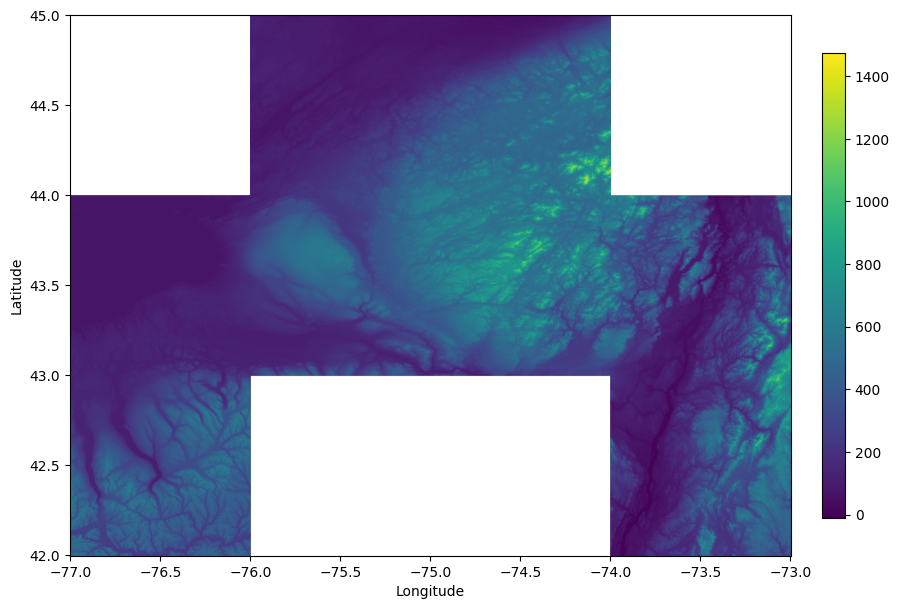

In [2]:
from rasterio.plot import show

merged_file = 'merged_mosaic.tif'
with rasterio.open(merged_file) as dataset:
  fig, ax = plt.subplots(figsize=(10, 10))
  img = rasterio.plot.show(dataset,
                             ax=ax)

  cbar = plt.colorbar(img.get_images()[0],
                        ax=ax,
                        orientation='vertical',
                        fraction=0.03,
                        pad=0.04)

  cbar.set_label('Elevation (meters)',
                   rotation=270,
                   labelpad=15)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

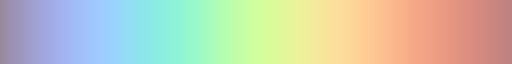

In [28]:
turbo_cmap = mpl.cm.turbo
turbo_cmap.set_under(color='k', alpha=.0)

turbo_cmap = mcolors.ListedColormap([(r, g, b, 0.5) for r, g, b, _ in turbo_cmap(np.arange(turbo_cmap.N))])
turbo_cmap

<Axes: >

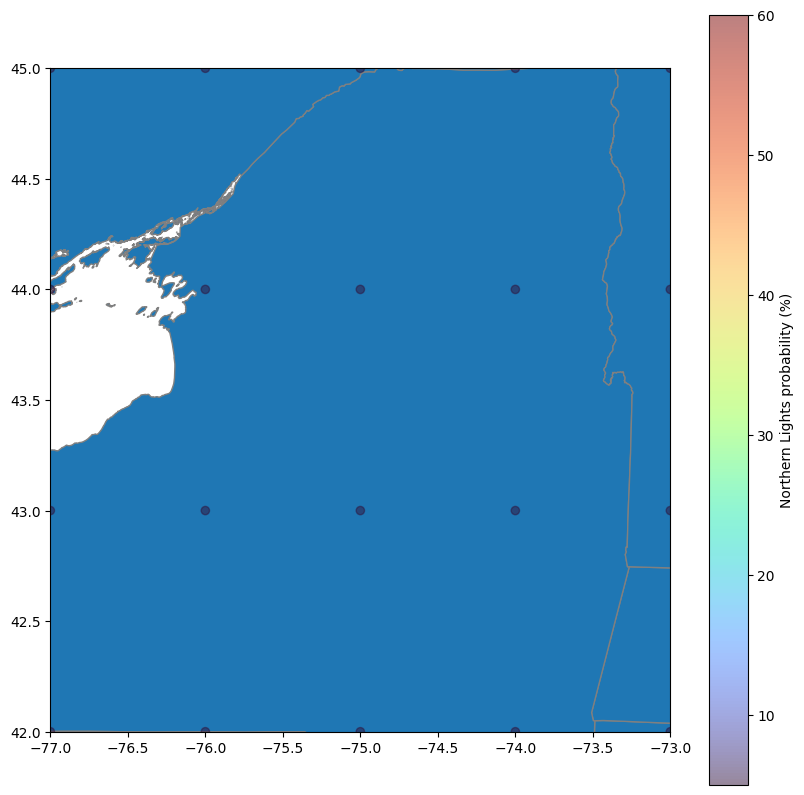

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-77, -73])
ax.set_ylim([42, 45])

new_york_gdf = na_gdf_4326.to_crs('EPSG:4269')
aurora_points_4269 = aurora_points.to_crs('EPSG:4269')

new_york_gdf.plot(ax=ax, edgecolor='grey', linewidth=1)

aurora_points_4269.plot(ax=ax, cmap=turbo_cmap, column='aurora',
                           vmin=5, legend=True, k=15,
                           label=f'Northern Lights on {display_date}',
                           legend_kwds={'ax':ax, 'label':'Northern Lights probability (%)'})

#